# Proyecto ISIS-3302 (Modelado, Optimización y Simulación)

- Paulina Arrazola Vernaza - 202020631
- Santiago Alejandro Jaimes Puerto - 201912921
- Nicolás Rincón Sánchez - 202021963

# Etapa III (Metaheurística)

## 1. Configuración y Procesamiento

### 1.1 Importación de Librerías

En el desarrollo de la implementación del proyecto, se requiere la instalación de librerías especializadas. En particular, se emplea como framework de optimización a Pyomo y se utilizan librerías para análisis de datos, como Pandas.

In [42]:
import pandas as pd
import numpy as np
import random
import math
import requests
import time
import os
import json # For OSRM caching
import itertools # For OSRM pair generation
from collections import OrderedDict # For OSRM cache ordering
import sys
import matplotlib.pyplot as plt
import csv

### 1.2 Carga de datos

In [43]:
OSRM_URL = "https://router.project-osrm.org/table/v1/driving/"
C_KM = 20700  # COP/km

# --- Global Data Store for the GA ---
# This will be populated by our adapted data loading
GA_DATA = {
    "depot_id": None,
    "depot_coords": None,
    "client_ids": [],
    "client_coords": {}, # {'C1': (lat, lon), ...}
    "client_demands": {}, # {'C1': demand, ...}
    "all_node_ids": [], # [depot_id, C1, C2, ...]
    "all_node_coords": {}, # {node_id: (lat, lon), ...}
    "homogeneous_vehicle_capacity": [],  # Lista de capacidades
    "homogeneous_vehicle_range": [],     # Lista de rangos
    "num_available_vehicles": 0,
    "distance_matrix": {}, # {(node1, node2): distance_km}
    "cost_matrix": {}, # {(node1, node2): cost_cop}
}

# === 1. DATA LOADING===


def load_and_prepare_data_for_ga(case_name_str):
    """
    Loads data for a specific case, adapts it for a single-depot,
    homogeneous fleet CVRP (with INFINITE vehicle capacity), and populates GA_DATA.
    All cases use depots.csv from CasoBase.
    Clients and Vehicles are from their respective case folders.
    """
    print(f"--- Loading and Preparing Data for Case: {case_name_str} ---")

    # Clear GA_DATA for fresh load
    GA_DATA["depot_id"] = None
    GA_DATA["depot_coords"] = None
    GA_DATA["client_ids"] = []
    GA_DATA["client_coords"] = {}
    GA_DATA["client_demands"] = {}
    GA_DATA["all_node_ids"] = []
    GA_DATA["all_node_coords"] = {}
    GA_DATA["homogeneous_vehicle_capacity"] = []  # Lista de capacidades
    GA_DATA["homogeneous_vehicle_range"] = []     # Lista de rangos
    GA_DATA["num_available_vehicles"] = 0
    GA_DATA["distance_matrix"] = {}
    GA_DATA["cost_matrix"] = {}

    base_data_path_prefix = "Etapa3/data/Proyecto_A_"
    depots_df_path = f"{base_data_path_prefix}CasoBase/depots.csv"

    if case_name_str == "Base":
        clients_df_path = f"{base_data_path_prefix}CasoBase/clients.csv"
        vehicles_df_path = f"{base_data_path_prefix}CasoBase/vehicles.csv"
    elif case_name_str == "2":
        clients_df_path = f"{base_data_path_prefix}Caso2/clients.csv"
        vehicles_df_path = f"{base_data_path_prefix}Caso2/vehicles.csv"
    elif case_name_str == "3":
        clients_df_path = f"{base_data_path_prefix}Caso3/clients.csv"
        vehicles_df_path = f"{base_data_path_prefix}Caso3/vehicles.csv"
    else:
        print(f"Error: Unknown case_name '{case_name_str}'", file=sys.stderr)
        sys.exit(1)

    print(f"  Depot path (fixed for all cases): {depots_df_path}")
    print(f"  Client path for Case {case_name_str}: {clients_df_path}")
    print(f"  Vehicle path for Case {case_name_str}: {vehicles_df_path}")

    try:
        depots_df = pd.read_csv(depots_df_path)
        if depots_df.empty:
            raise ValueError(f"Depots CSV ({depots_df_path}) is empty or not found.")
        first_depot_row = depots_df.iloc[0]
        GA_DATA["depot_id"] = f"D{int(first_depot_row['DepotID'])}"
        GA_DATA["depot_coords"] = (float(first_depot_row['Latitude']), float(first_depot_row['Longitude']))
        GA_DATA["all_node_ids"].append(GA_DATA["depot_id"])
        GA_DATA["all_node_coords"][GA_DATA["depot_id"]] = GA_DATA["depot_coords"]
        print(f"Selected Depot: {GA_DATA['depot_id']} at {GA_DATA['depot_coords']}")

        clients_df = pd.read_csv(clients_df_path)
        if clients_df.empty:
            raise ValueError(f"Clients CSV ({clients_df_path}) is empty or not found.")
        if 'Demand' not in clients_df.columns:
            raise ValueError(f"Critical: 'Demand' column missing in {clients_df_path}.")
        for idx, row in clients_df.iterrows():
            client_id_val = row['ClientID']
            if isinstance(client_id_val, float) and client_id_val.is_integer():
                client_id_val = int(client_id_val)
            client_id_str = f"C{client_id_val}"
            GA_DATA["client_ids"].append(client_id_str)
            GA_DATA["all_node_ids"].append(client_id_str)
            client_coords = (float(row['Latitude']), float(row['Longitude']))
            GA_DATA["client_coords"][client_id_str] = client_coords
            GA_DATA["all_node_coords"][client_id_str] = client_coords
            GA_DATA["client_demands"][client_id_str] = float(row['Demand']) # Demand still loaded, but not used by capacity check if capacity is Inf
        print(f"Loaded {len(GA_DATA['client_ids'])} clients for Case {case_name_str}. First few: {GA_DATA['client_ids'][:5]}")

        # Modificar la sección de carga de vehículos
        vehicles_df = pd.read_csv(vehicles_df_path)
        if vehicles_df.empty:
            raise ValueError(f"Vehicles CSV ({vehicles_df_path}) is empty or not found.")
        if 'Range' not in vehicles_df.columns or 'Capacity' not in vehicles_df.columns:
            raise ValueError(f"Critical: 'Range' or 'Capacity' column missing in {vehicles_df_path}.")
        
        # Cargar rangos y capacidades como listas
        GA_DATA["homogeneous_vehicle_range"] = vehicles_df['Range'].tolist()
        GA_DATA["homogeneous_vehicle_capacity"] = vehicles_df['Capacity'].tolist()
        GA_DATA["num_available_vehicles"] = len(vehicles_df)
        print(f"Fleet for Case {case_name_str}:")
        print(f"  Number of vehicles: {GA_DATA['num_available_vehicles']}")
        print(f"  Ranges: {GA_DATA['homogeneous_vehicle_range'][:3]}... (showing first 3)")
        print(f"  Capacities: {GA_DATA['homogeneous_vehicle_capacity'][:3]}... (showing first 3)")

    except FileNotFoundError as e:
        print(f"Error: File not found. {e}", file=sys.stderr)
        sys.exit(1)
    except ValueError as e: 
        print(f"Error: Data validation or column name issue. {e}", file=sys.stderr)
        sys.exit(1)
    except KeyError as e: 
        print(f"Error: Missing expected column in CSV (KeyError). Problematic column: {e}. Please check CSV headers.", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}", file=sys.stderr)
        sys.exit(1)


    # --- OSRM Distance Calculation ---
    print("--- Calculating Distance Matrix using OSRM ---")
    N_ga = GA_DATA["all_node_ids"]
    coords_ga = GA_DATA["all_node_coords"]
    if not GA_DATA["client_ids"]:
         print(f"CRITICAL: No clients were loaded for Case {case_name_str}. GA cannot proceed effectively.", file=sys.stderr)
    CACHE_FILE_GA = f'Etapa3/cache/osrm_cache_ga_{case_name_str.lower().replace(" ", "_")}.json'
    os.makedirs(os.path.dirname(CACHE_FILE_GA), exist_ok=True)

    dist_cache = {}
    if os.path.exists(CACHE_FILE_GA):
        try:
            with open(CACHE_FILE_GA, 'r') as f:
                raw_cache = json.load(f)
            dist_cache = {tuple(k.split("|")): v for k, v in raw_cache.items()}
            print(f"  Distances loaded from GA cache ({len(dist_cache)} pairs): {CACHE_FILE_GA}")
        except json.JSONDecodeError:
            print(f"  Warning: Cache file {CACHE_FILE_GA} is corrupted. Rebuilding.")
            dist_cache = {}
    
    all_pairs_to_calculate = list(itertools.product(N_ga, N_ga))
    missing_pairs = [p for p in all_pairs_to_calculate if p not in dist_cache and p[0] != p[1]] 

    MAX_COORDS_OSRM = 100 

    if missing_pairs:
        print(f"  Calculating {len(missing_pairs)} missing distance pairs via OSRM...")
        BATCH_SIZE = max(1, MAX_COORDS_OSRM // 2) 
        
        for i_start_node_batch_start in range(0, len(N_ga), BATCH_SIZE):
            sources_nodes = N_ga[i_start_node_batch_start : i_start_node_batch_start + BATCH_SIZE]
            
            for j_start_node_batch_start in range(0, len(N_ga), BATCH_SIZE):
                dests_nodes = N_ga[j_start_node_batch_start : j_start_node_batch_start + BATCH_SIZE]
                
                current_query_nodes = list(OrderedDict.fromkeys(sources_nodes + dests_nodes)) 
                if not current_query_nodes: continue

                node_to_idx_map = {node_id: k for k, node_id in enumerate(current_query_nodes)}
                query_coords_str = ";".join([f"{coords_ga[n][1]},{coords_ga[n][0]}" for n in current_query_nodes])
                
                src_indices_in_query = ";".join(str(node_to_idx_map[n]) for n in sources_nodes if n in node_to_idx_map)
                dst_indices_in_query = ";".join(str(node_to_idx_map[n]) for n in dests_nodes if n in node_to_idx_map)

                if not src_indices_in_query or not dst_indices_in_query: continue

                url_batch = f"{OSRM_URL}{query_coords_str}"
                params_batch = {
                    "sources": src_indices_in_query,
                    "destinations": dst_indices_in_query,
                    "annotations": "distance"
                }
                
                # print(f"    Querying OSRM batch: {len(sources_nodes)} sources vs {len(dests_nodes)}. Query nodes: {len(current_query_nodes)}") # Can be verbose

                try:
                    r = requests.get(url_batch, params=params_batch, timeout=180)
                    r.raise_for_status()
                    matrix_data = r.json()
                    if "distances" not in matrix_data or not matrix_data["distances"]:
                        # print(f"    Warning: OSRM batch returned empty/invalid distances matrix for {sources_nodes} to {dests_nodes}.") # Can be verbose
                        for u_node_s in sources_nodes:
                            for v_node_d in dests_nodes:
                                if (u_node_s, v_node_d) not in dist_cache: dist_cache[(u_node_s, v_node_d)] = float('inf')
                        continue
                    
                    batch_distances = matrix_data["distances"]
                    for src_idx_local, u_node_s in enumerate(sources_nodes):
                        for dst_idx_local, v_node_d in enumerate(dests_nodes):
                            if u_node_s == v_node_d:
                                dist_cache[(u_node_s, v_node_d)] = 0.0
                                continue
                            if src_idx_local < len(batch_distances) and dst_idx_local < len(batch_distances[src_idx_local]):
                                dist_val = batch_distances[src_idx_local][dst_idx_local]
                                dist_cache[(u_node_s, v_node_d)] = float('inf') if dist_val is None else dist_val / 1000.0
                            else:
                                # print(f"    Warning: Index out of bounds for OSRM batch_distances for ({u_node_s}, {v_node_d}). Assigning Inf.") # Can be verbose
                                dist_cache[(u_node_s, v_node_d)] = float('inf')

                except requests.exceptions.Timeout:
                    print(f"    Error: OSRM request timed out for batch. Assigning Inf.")
                    for u_node_s in sources_nodes:
                        for v_node_d in dests_nodes:
                            if (u_node_s, v_node_d) not in dist_cache: dist_cache[(u_node_s, v_node_d)] = float('inf')
                except requests.exceptions.RequestException as e_req:
                    print(f"    Error: OSRM request failed for batch: {e_req}. Assigning Inf.")
                    for u_node_s in sources_nodes:
                        for v_node_d in dests_nodes:
                            if (u_node_s, v_node_d) not in dist_cache: dist_cache[(u_node_s, v_node_d)] = float('inf')
        
        ordered_dist_cache_to_save = OrderedDict()
        sorted_nodes_for_cache = sorted(N_ga) 
        for u_node in sorted_nodes_for_cache:
            for v_node in sorted_nodes_for_cache:
                ordered_dist_cache_to_save[f"{u_node}|{v_node}"] = dist_cache.get((u_node, v_node), float('inf') if u_node !=v_node else 0.0)

        with open(CACHE_FILE_GA, 'w') as f:
            json.dump(ordered_dist_cache_to_save, f, indent=2)
        print(f"  GA OSRM cache updated: {CACHE_FILE_GA}")
    else:
        print(f"  No missing distance pairs for Case {case_name_str}. Using existing cache: {CACHE_FILE_GA}")

    # Populate GA_DATA distance and cost matrices
    for u_node in N_ga:
        for v_node in N_ga:
            if u_node == v_node:
                GA_DATA["distance_matrix"][(u_node, v_node)] = 0.0
                GA_DATA["cost_matrix"][(u_node, v_node)] = 0.0
            else:
                dist = dist_cache.get((u_node, v_node), float('inf'))
                GA_DATA["distance_matrix"][(u_node, v_node)] = dist
                GA_DATA["cost_matrix"][(u_node, v_node)] = dist * C_KM
    
    print(f"Distance and Cost matrices populated for Case {case_name_str}. {len(GA_DATA['distance_matrix'])} entries.")
    if GA_DATA["depot_id"] in GA_DATA["client_ids"]: 
        print(f"CRITICAL ERROR: Depot ID {GA_DATA['depot_id']} is also in client_ids list for Case {case_name_str}!", file=sys.stderr)
        sys.exit(1)
    print(f"--- Data Loading and Preparation Complete for Case {case_name_str} ---")




In [47]:
# Visualize the dictionary as a DataFrame to check the dats
def visualize_ga_data():
    """
    Visualizes the GA_DATA dictionary as a DataFrame for debugging.
    """
    print("--- Visualizing GA_DATA ---")
    df = pd.DataFrame.from_dict(GA_DATA, orient='index')
    print(df)
    print("--- Visualization Complete ---")

visualize_ga_data()

--- Visualizing GA_DATA ---


                                                                              0
depot_id                                                                     D1
depot_coords                                             (4.743359, -74.153536)
client_ids                    [C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11,...
client_coords                 {'C1': (4.59795431125545, -74.09893796560621),...
client_demands                {'C1': 13.0, 'C2': 15.0, 'C3': 12.0, 'C4': 15....
all_node_ids                  [D1, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, ...
all_node_coords               {'D1': (4.743359, -74.153536), 'C1': (4.597954...
homogeneous_vehicle_capacity             [130, 140, 120, 100, 70, 55, 110, 114]
homogeneous_vehicle_range               [170, 200, 180, 90, 100, 170, 150, 140]
num_available_vehicles                                                        8
distance_matrix               {('D1', 'D1'): 0.0, ('D1', 'C1'): 27.144299999...
cost_matrix                   {('D1', 'D

### 2. GENETIC ALGORITHM FOR CVRP

In [45]:
def decode_chromosome_to_routes(chromosome, data):
    """
    Decodes a chromosome (permutation of client_ids) into a list of routes.
    Each route starts and ends at the depot and respects vehicle-specific capacity and range.
    """
    routes = []
    current_route_nodes = [data["depot_id"]]
    current_route_capacity_load = 0
    current_route_distance_travelled = 0
    current_vehicle_idx = 0
    
    total_solution_cost = 0
    feasibility_penalty = 0
    clients_to_visit_ordered = list(chromosome)
    chromosome_client_idx = 0

    while chromosome_client_idx < len(clients_to_visit_ordered):
        if current_vehicle_idx >= data["num_available_vehicles"]:
            remaining_unserved = len(clients_to_visit_ordered) - chromosome_client_idx
            feasibility_penalty += remaining_unserved * 10_000_000
            break

        client_id_to_try = clients_to_visit_ordered[chromosome_client_idx]
        client_demand = data["client_demands"].get(client_id_to_try, float('inf'))
        current_vehicle_capacity = data["homogeneous_vehicle_capacity"][current_vehicle_idx]
        current_vehicle_range = data["homogeneous_vehicle_range"][current_vehicle_idx]

        needs_new_vehicle = (len(current_route_nodes) == 1 and current_route_nodes[0] == data["depot_id"])
        
        if needs_new_vehicle:
            current_route_capacity_load = 0
            current_route_distance_travelled = 0

        can_add_this_client = True
        last_node = current_route_nodes[-1]
        dist_to_client = data["distance_matrix"].get((last_node, client_id_to_try), float('inf'))
        dist_to_depot = data["distance_matrix"].get((client_id_to_try, data["depot_id"]), float('inf'))

        # Verificar capacidad y distancia
        if dist_to_client == float('inf') or dist_to_depot == float('inf'):
            can_add_this_client = False
            feasibility_penalty += 20_000_000

        new_load = current_route_capacity_load + client_demand
        new_distance = current_route_distance_travelled + dist_to_client + dist_to_depot

        if new_load > current_vehicle_capacity:
            can_add_this_client = False
        
        if new_distance > current_vehicle_range:
            can_add_this_client = False

        if can_add_this_client:
            current_route_nodes.append(client_id_to_try)
            current_route_capacity_load = new_load
            current_route_distance_travelled += dist_to_client
            chromosome_client_idx += 1
        else:
            if needs_new_vehicle:
                feasibility_penalty += 50_000_000
                chromosome_client_idx += 1
            else:
                if len(current_route_nodes) > 1:
                    dist_return = data["distance_matrix"].get((current_route_nodes[-1], data["depot_id"]), float('inf'))
                    if dist_return == float('inf'):
                        feasibility_penalty += 20_000_000
                    else:
                        final_route_dist = current_route_distance_travelled + dist_return
                        total_solution_cost += final_route_dist * C_KM
                    routes.append((current_vehicle_idx, list(current_route_nodes) + [data["depot_id"]]))
                current_route_nodes = [data["depot_id"]]
                current_route_capacity_load = 0
                current_route_distance_travelled = 0
                current_vehicle_idx += 1

    # Completar última ruta si es necesario
    if len(current_route_nodes) > 1:
        dist_return_last = data["distance_matrix"].get((current_route_nodes[-1], data["depot_id"]), float('inf'))
        if dist_return_last == float('inf'):
            feasibility_penalty += 20_000_000
        else:
            final_route_dist = current_route_distance_travelled + dist_return_last
            total_solution_cost += final_route_dist * C_KM
        routes.append((current_vehicle_idx, list(current_route_nodes) + [data["depot_id"]]))

    # Verificar clientes no servidos
    served_clients = set()
    for _, route in routes:
        for node in route:
            if node != data["depot_id"]:
                served_clients.add(node)

    for client in chromosome:
        if client not in served_clients:
            feasibility_penalty += 1_000_000

    return routes, total_solution_cost, feasibility_penalty


def calculate_cvrp_fitness(chromosome_individual, data):
    """
    Calculates the fitness of an individual (chromosome).
    Lower fitness (cost) is better.
    """
    # Ensure chromosome contains all clients exactly once
    if sorted(chromosome_individual) != sorted(data["client_ids"]):
        # This should not happen if population generation and operators are correct
        return float('inf') # Invalid chromosome

    routes, decoded_cost, penalty = decode_chromosome_to_routes(chromosome_individual, data)
    
    fitness = decoded_cost + penalty
    return fitness

def generate_initial_population(size, client_ids_list):
    population = []
    for _ in range(size):
        individual = list(client_ids_list) # Make a mutable copy
        random.shuffle(individual)
        population.append(individual)
    return population

# Selection, Crossover, Mutation from your example (suitable for permutations)
def selection_by_tournament(population, fitness_func, data, k=3):
    selected_parents = []
    for _ in range(len(population)):
        participants = random.sample(population, k)
        # Calculate fitness for participants on the fly
        participant_fitnesses = [fitness_func(ind, data) for ind in participants]
        winner = participants[participant_fitnesses.index(min(participant_fitnesses))]
        selected_parents.append(list(winner)) # Store a copy
    return selected_parents

def order_crossover_ox(parent1, parent2):
    size = len(parent1)
    child = [None] * size
    
    # Select two random crossover points
    start, end = sorted(random.sample(range(size), 2))
    
    # Copy the segment from parent1 to child
    child[start:end+1] = parent1[start:end+1]
    
    # Fill the remaining positions from parent2
    # Create a list of elements from parent2 that are not in the copied segment
    parent2_elements = [item for item in parent2 if item not in child[start:end+1]]
    
    current_pos = 0
    for i in range(size):
        if child[i] is None:
            child[i] = parent2_elements[current_pos]
            current_pos += 1
    return child

def swap_mutation(individual, mutation_rate):
    mutated_individual = list(individual) # Work on a copy
    if random.random() < mutation_rate:
        idx1, idx2 = random.sample(range(len(mutated_individual)), 2)
        mutated_individual[idx1], mutated_individual[idx2] = mutated_individual[idx2], mutated_individual[idx1]
    return mutated_individual

# Main Genetic Algorithm
def run_genetic_algorithm_cvrp(data, pop_size=50, generations=100, mutation_rate=0.05, tournament_k=3):
    print("\n--- Starting Genetic Algorithm for CVRP ---")
    client_ids_list = data["client_ids"]
    
    population = generate_initial_population(pop_size, client_ids_list)
    
    best_overall_fitness = float('inf')
    best_overall_chromosome = None
    
    generation_log = []

    for gen in range(generations):
        # Evaluate fitness for the current population
        fitness_values = [calculate_cvrp_fitness(ind, data) for ind in population]
        
        # Find best in current generation
        min_fitness_current_gen = min(fitness_values)
        best_chromosome_current_gen = population[fitness_values.index(min_fitness_current_gen)]
        
        if min_fitness_current_gen < best_overall_fitness:
            best_overall_fitness = min_fitness_current_gen
            best_overall_chromosome = list(best_chromosome_current_gen) # Store a copy
        
        avg_fitness_current_gen = sum(fitness_values) / len(fitness_values)
        generation_log.append((gen + 1, best_overall_fitness, avg_fitness_current_gen))
        print(f"Generation {gen+1}/{generations} | Best Fitness: {best_overall_fitness:.2f} | Avg Fitness: {avg_fitness_current_gen:.2f}")
        
        # Selection
        parents = selection_by_tournament(population, calculate_cvrp_fitness, data, k=tournament_k)
        
        # Crossover and Mutation
        next_population = []
        # Elitism: carry over the best individual from current pop if desired (optional)
        # For now, standard replacement:
        
        for i in range(0, pop_size, 2):
            if i + 1 < len(parents): # Ensure we have pairs
                p1 = parents[i]
                p2 = parents[i+1] # If pop_size is odd, last parent might be unused or paired with random
                
                child1 = order_crossover_ox(p1, p2)
                child2 = order_crossover_ox(p2, p1) # OX is not symmetric necessarily
                
                child1_mutated = swap_mutation(child1, mutation_rate)
                child2_mutated = swap_mutation(child2, mutation_rate)
                
                next_population.append(child1_mutated)
                next_population.append(child2_mutated)
            elif i < len(parents): # Handle odd population size if parents list becomes odd
                next_population.append(parents[i])


        if len(next_population) < pop_size : # If pop_size was odd, parents list might be odd
             # Fill up if needed (e.g., by adding some of the best parents again or random new individuals)
             # For simplicity, if it happens, we can just duplicate the last one or take a random parent
             if parents:
                 needed = pop_size - len(next_population)
                 for _ in range(needed):
                    next_population.append(swap_mutation(random.choice(parents), mutation_rate)) # add mutated random parent


        population = next_population[:pop_size] # Ensure population size is maintained

    print("--- Genetic Algorithm Finished ---")
    return best_overall_chromosome, best_overall_fitness, generation_log

### 3. OUTPUT AND VISUALIZATION

Attempting to solve CVRP for: Caso Base
--- Loading and Preparing Data for Case: Base ---
  Depot path (fixed for all cases): Etapa3/data/Proyecto_A_CasoBase/depots.csv
  Client path for Case Base: Etapa3/data/Proyecto_A_CasoBase/clients.csv
  Vehicle path for Case Base: Etapa3/data/Proyecto_A_CasoBase/vehicles.csv
Selected Depot: D1 at (4.743359, -74.153536)
Loaded 24 clients for Case Base. First few: ['C1', 'C2', 'C3', 'C4', 'C5']
Fleet for Case Base:
  Number of vehicles: 8
  Ranges: [170, 200, 180]... (showing first 3)
  Capacities: [130, 140, 120]... (showing first 3)
--- Calculating Distance Matrix using OSRM ---
  Distances loaded from GA cache (625 pairs): Etapa3/cache/osrm_cache_ga_base.json
  No missing distance pairs for Case Base. Using existing cache: Etapa3/cache/osrm_cache_ga_base.json
Distance and Cost matrices populated for Case Base. 625 entries.
--- Data Loading and Preparation Complete for Case Base ---

--- Starting Genetic Algorithm for CVRP ---
Generation 1/200 |

C:\Users\nicol\AppData\Local\Temp\ipykernel_1712\1480389691.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(routes)) # Get a colormap


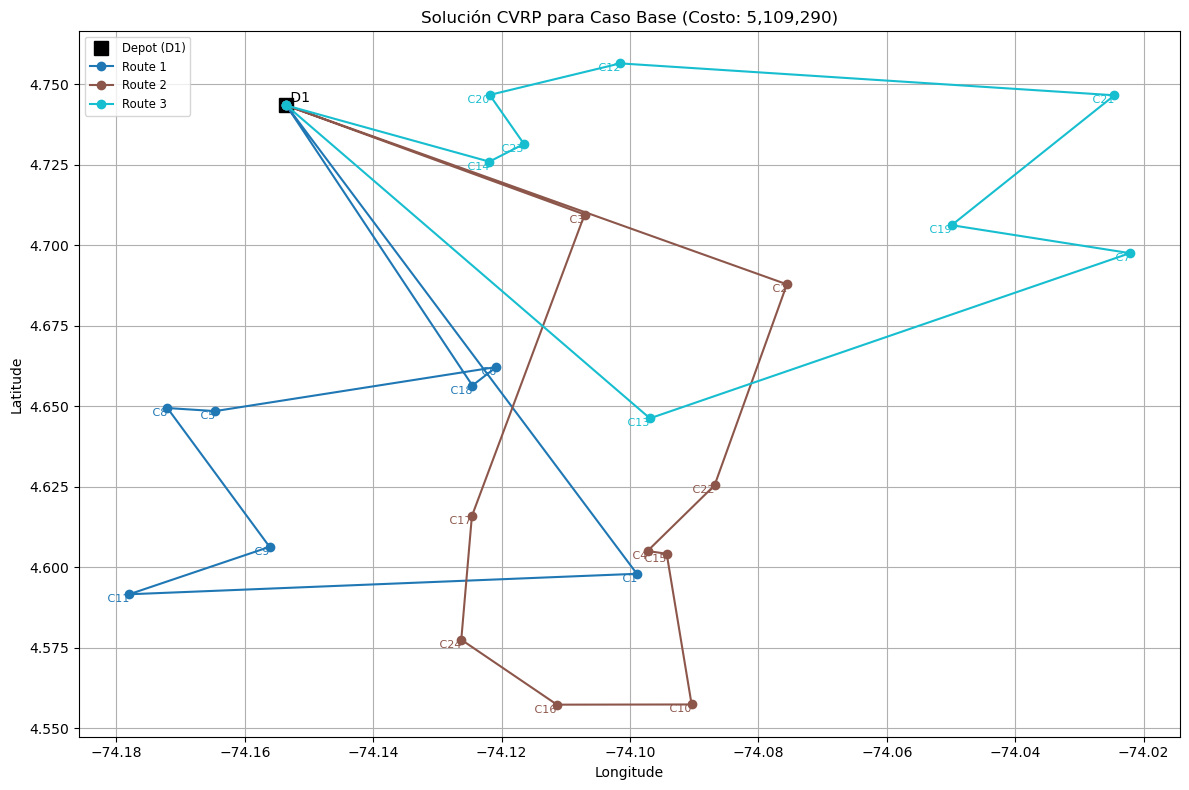

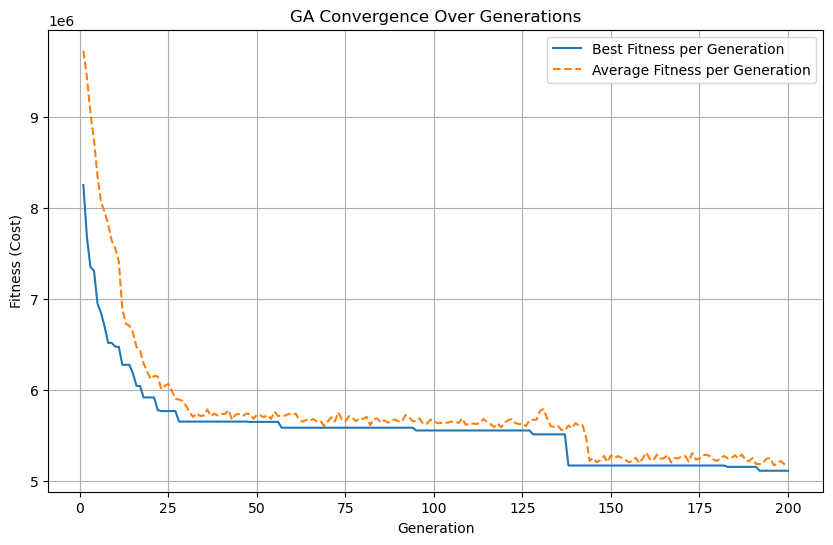

Solution saved to cvrp_solution_case_Base.csv
Attempting to solve CVRP for: Caso 2
--- Loading and Preparing Data for Case: 2 ---
  Depot path (fixed for all cases): Etapa3/data/Proyecto_A_CasoBase/depots.csv
  Client path for Case 2: Etapa3/data/Proyecto_A_Caso2/clients.csv
  Vehicle path for Case 2: Etapa3/data/Proyecto_A_Caso2/vehicles.csv
Selected Depot: D1 at (4.743359, -74.153536)
Loaded 9 clients for Case 2. First few: ['C1', 'C2', 'C3', 'C4', 'C5']
Fleet for Case 2:
  Number of vehicles: 6
  Ranges: [145.85207096486445, 1304.605971281605, 953.172608610164]... (showing first 3)
  Capacities: [131.9211396722696, 108.4356199315333, 91.50425520531196]... (showing first 3)
--- Calculating Distance Matrix using OSRM ---
  Distances loaded from GA cache (100 pairs): Etapa3/cache/osrm_cache_ga_2.json
  No missing distance pairs for Case 2. Using existing cache: Etapa3/cache/osrm_cache_ga_2.json
Distance and Cost matrices populated for Case 2. 100 entries.
--- Data Loading and Preparati

C:\Users\nicol\AppData\Local\Temp\ipykernel_1712\1480389691.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(routes)) # Get a colormap


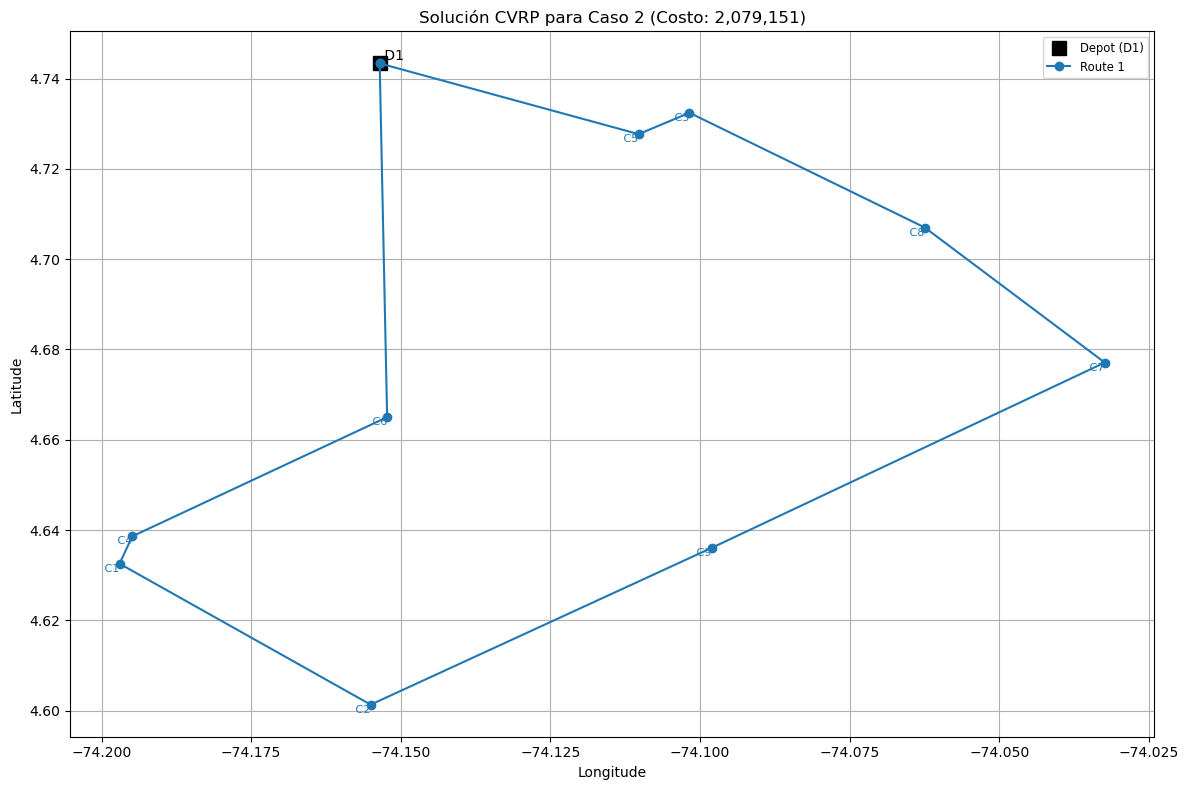

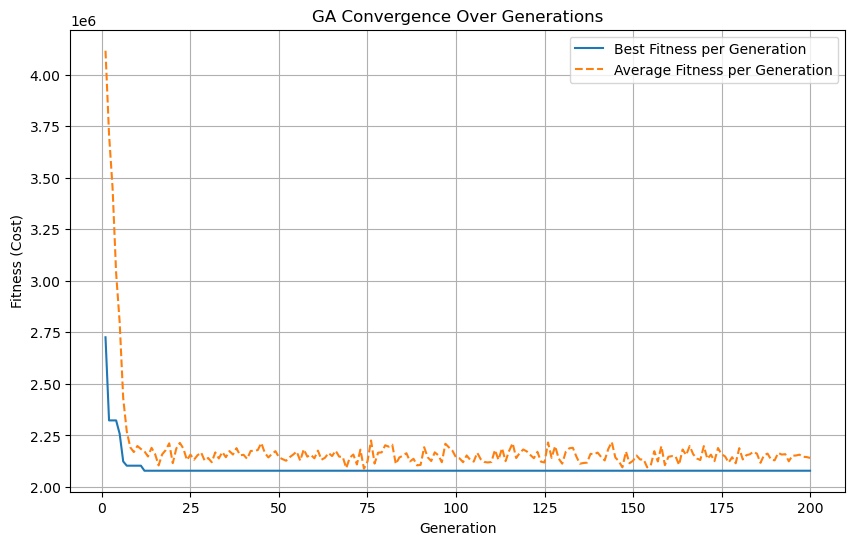

Solution saved to cvrp_solution_case_2.csv
Attempting to solve CVRP for: Caso 3
--- Loading and Preparing Data for Case: 3 ---
  Depot path (fixed for all cases): Etapa3/data/Proyecto_A_CasoBase/depots.csv
  Client path for Case 3: Etapa3/data/Proyecto_A_Caso3/clients.csv
  Vehicle path for Case 3: Etapa3/data/Proyecto_A_Caso3/vehicles.csv
Selected Depot: D1 at (4.743359, -74.153536)
Loaded 90 clients for Case 3. First few: ['C1', 'C2', 'C3', 'C4', 'C5']
Fleet for Case 3:
  Number of vehicles: 30
  Ranges: [146, 196, 143]... (showing first 3)
  Capacities: [132, 136, 115]... (showing first 3)
--- Calculating Distance Matrix using OSRM ---
  Distances loaded from GA cache (8281 pairs): Etapa3/cache/osrm_cache_ga_3.json
  No missing distance pairs for Case 3. Using existing cache: Etapa3/cache/osrm_cache_ga_3.json
Distance and Cost matrices populated for Case 3. 8281 entries.
--- Data Loading and Preparation Complete for Case 3 ---

--- Starting Genetic Algorithm for CVRP ---
Generation 

C:\Users\nicol\AppData\Local\Temp\ipykernel_1712\1480389691.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(routes)) # Get a colormap


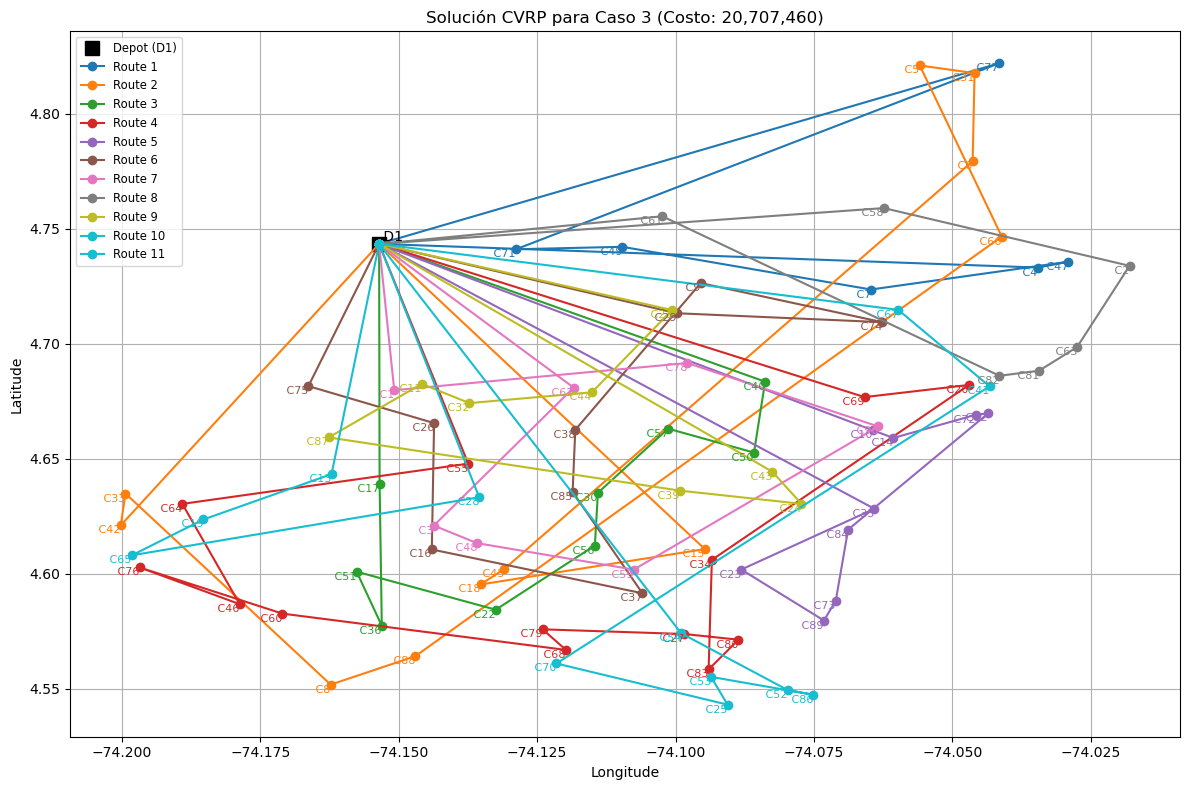

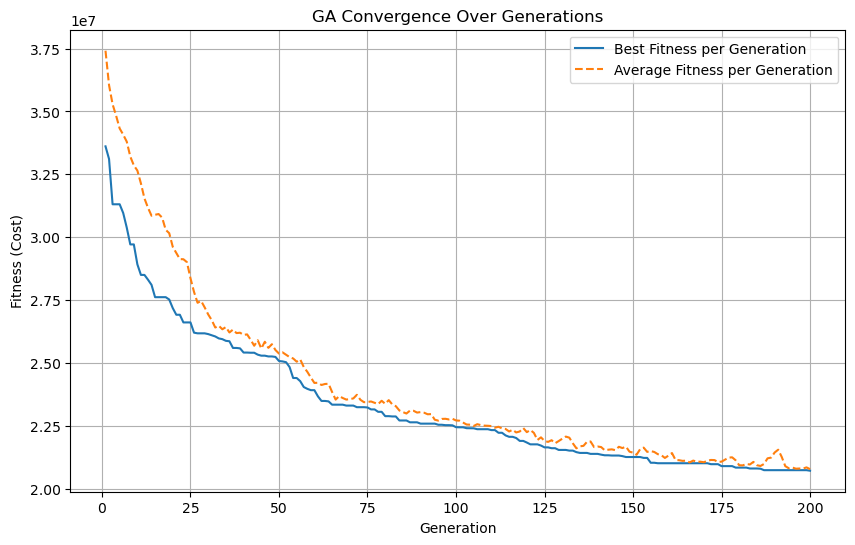

Solution saved to cvrp_solution_case_3.csv


In [ ]:
import time

for target_case_name in ['Base', '2', '3']:
    print(f"\n{'='*60}")
    print(f"Attempting to solve CVRP for: Caso {target_case_name}")

    load_and_prepare_data_for_ga(target_case_name)

    unserviceable_clients = []
    for cid, dem in GA_DATA["client_demands"].items():
        if dem > max(GA_DATA["homogeneous_vehicle_capacity"]):
            unserviceable_clients.append((cid, dem))
    if unserviceable_clients:
        print("\nWARNING: The following clients have demands greater than available vehicle capacities:")
        for cid, dem in unserviceable_clients:
            print(f"  - {cid}: Demand {dem}")
        print("These clients will likely lead to high penalties or prevent a fully feasible solution.\n")

    if not GA_DATA["client_ids"]:
        print("No clients loaded. Exiting.")

    POPULATION_SIZE = 100
    GENERATIONS = 200 
    MUTATION_RATE = 0.10
    TOURNAMENT_K = 5

    # Iniciar temporizador
    start_time = time.time()

    best_chromosome, best_fitness, ga_log = run_genetic_algorithm_cvrp(
        GA_DATA,
        pop_size=POPULATION_SIZE,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        tournament_k=TOURNAMENT_K
    )

    # Finalizar temporizador
    end_time = time.time()
    elapsed_time = end_time - start_time

    if best_chromosome:
        print("\n=== Best Solution Found ===")
        final_routes, final_cost, final_penalty = decode_chromosome_to_routes(best_chromosome, GA_DATA)
        
        print(f"\nBest Chromosome Order: {' → '.join(best_chromosome)}")
        print(f"\nDecoded Routes ({len(final_routes)} routes):")
        total_dist_check = 0
        
        for i, (vehicle_idx, route) in enumerate(final_routes):
            route_dist = 0
            route_demand = 0
            vehicle_capacity = GA_DATA["homogeneous_vehicle_capacity"][vehicle_idx]
            vehicle_range = GA_DATA["homogeneous_vehicle_range"][vehicle_idx]
            
            for k_idx in range(len(route) - 1):
                u, v = route[k_idx], route[k_idx+1]
                route_dist += GA_DATA["distance_matrix"].get((u,v), float('inf'))
                if v != GA_DATA["depot_id"]:
                    route_demand += GA_DATA["client_demands"].get(v,0)
            
            total_dist_check += route_dist
            print(f"\nRuta {i+1} (Vehículo {vehicle_idx+1}):")
            print(f"  Secuencia: {' → '.join(route)}")
            print(f"  Capacidad: {route_demand:.1f}/{vehicle_capacity:.1f}")
            print(f"  Distancia: {route_dist:.1f}/{vehicle_range:.1f} km")
        
        print(f"\nResumen de la Solución:")
        print(f"  Costo Total: {final_cost + final_penalty:,.2f} COP")
        print(f"  Distancia Total: {total_dist_check:.2f} km")
        print(f"  Vehículos Usados: {len(final_routes)}/{GA_DATA['num_available_vehicles']}")
        if final_penalty > 0:
            print(f"  ALERTA: La solución tiene penalizaciones: {final_penalty:,.2f}")
        
        print(f"  Tiempo de ejecución del GA: {elapsed_time:.2f} segundos")
        
        plot_routes = [route for _, route in final_routes]
        plot_cvrp_solution(plot_routes, GA_DATA["depot_id"], GA_DATA["all_node_coords"], 
                      title=f"Solución CVRP para Caso {target_case_name} (Costo: {best_fitness:,.0f})")
        plot_ga_convergence(ga_log)
        save_solution_to_csv(plot_routes, GA_DATA["depot_id"], 
                        filename=f"cvrp_solution_case_{target_case_name}.csv")
    else:
        print("No se encontró solución.")
